# FicEmbed Training Run on Romeo and Juliet

## Installs and Imports

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses
!pip install transformers
!pip install torch

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from sklearn.manifold import TSNE
import plotly.express as px
import pickle

In [ ]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_device

## Network Architecture

In [ ]:
class GraphConvolution(torch.nn.Module):
    def __init__(self, character_embedding_dim, edge_dim):
        super(GraphConvolution, self).__init__()

        self.ce_dim = character_embedding_dim
        self.e_dim = edge_dim

        self.activation = nn.Sigmoid()
        
        self.message_to_listener = nn.Sequential(nn.Linear(character_embedding_dim + edge_dim, character_embedding_dim),
                                                self.activation)
        
        self.message_to_speaker = nn.Sequential(nn.Linear(character_embedding_dim + edge_dim, character_embedding_dim),
                                                self.activation)
        
        self.listener_update = nn.Sequential(nn.Linear(character_embedding_dim, character_embedding_dim), self.activation)
        self.speaker_update = nn.Sequential(nn.Linear(character_embedding_dim, character_embedding_dim), self.activation)

    def forward(self, character_embeddings, dialogue_embeddings, speakers, listeners):
        '''
          -> (speakers intersect listeners) should be an empty set!
        '''

        character_embeddings = character_embeddings.detach()

        speaker_features = character_embeddings[speakers, :]
        listener_features = character_embeddings[listeners, :]

        speaker_listener_dialogue =  torch.cat((speaker_features - listener_features, dialogue_embeddings), dim=-1)

        # Residual connection included to avoid dying gradients
        updated_speakers = self.speaker_update(speaker_features + self.message_to_listener(speaker_listener_dialogue)) + speaker_features 
        updated_listeners = self.listener_update(listener_features + self.message_to_speaker(speaker_listener_dialogue)) + listener_features 

        out = character_embeddings.clone()
        out[speakers, :] = updated_speakers
        out[listeners, :] = updated_listeners

        return out

class GCLWithHeadBert(torch.nn.Module):
  def __init__(self, character_embedding_dim, bert_dim, edge_dim, out_dim):
    super(GCLWithHeadBert, self).__init__()

    self.bert_dim = bert_dim
    self.head = nn.Linear(2 * character_embedding_dim, out_dim)
    self.edge_translator = nn.Linear(bert_dim, edge_dim)
    self.gcn_layer = GraphConvolution(character_embedding_dim, edge_dim)
    self.activation = nn.Sigmoid()

  def forward(self, character_embeddings, embedding, speaker, listener):
    edge_feature = self.activation(self.edge_translator(embedding.detach())[None, :])
    updated_embeddings = self.gcn_layer(character_embeddings, edge_feature, speaker, listener)
    linear_layer_out = self.activation(self.head(torch.cat((updated_embeddings[speaker, :], updated_embeddings[listener, :]), axis=1)))
    return updated_embeddings, linear_layer_out


## Data Import and Wrangling

In [70]:
df_dialogs = pd.read_csv('rj_vadr_bert.csv').drop(columns=["Unnamed: 0"])
character_enum = pd.DataFrame(df_dialogs["speaker"].unique()).reset_index().rename(columns={0:'character'})
df_dialogs_with_speaker_enumeration = pd.merge(left=df_dialogs,
                                       right=character_enum,
                                       left_on="speaker",
                                       right_on="character",
                                       how="left").rename(columns={'index': 'speaker_index'}).drop(columns=['character'])
df_dialogs_with_listener_enumeration = pd.merge(left=df_dialogs_with_speaker_enumeration,
                                       right=character_enum,
                                       left_on="listener",
                                       right_on="character",
                                       how="left").rename(columns={'index': 'listener_index'}).drop(columns=['character'])
data_d = df_dialogs_with_listener_enumeration[['speaker', 'listener', 'speaker_index', 'listener_index', 'dialogue', 'dialogue_sentiment', 'avg_sentiment', 'bert']]
data = data_d.T.drop_duplicates().T
data

,speaker,listener,speaker_index,listener_index,dialogue,dialogue_sentiment,avg_sentiment,bert
0,CHORUS,SAMPSON,0,1,"Two households, both alike in dignity, In fair...",-0.5719,-0.5719,"[-0.062187887728214264, 0.04341184347867966, 0..."
1,SAMPSON,CHORUS,1,0,"Gregory, on my word, we’ll not carry coals.",0.0,0.0,"[-0.14115169644355774, 0.5629909634590149, -0...."
2,SAMPSON,GREGORY,1,2,"Gregory, on my word, we’ll not carry coals.",0.0,-0.062038,"[-0.14115169644355774, 0.5629909634590149, -0...."
3,GREGORY,SAMPSON,2,1,"No, for then we should be colliers.",0.0,-0.087993,"[-0.1291680932044983, 0.28564387559890747, -0...."
4,GREGORY,SAMPSON,2,1,"No, for then we should be colliers.",0.0,-0.087993,"[-0.1291680932044983, 0.28564387559890747, -0...."
...,...,...,...,...,...,...,...,...
1681,MONTAGUE,CAPULET,9,7,"But I can give thee more, For I will raise her...",0.6956,0.2643,"[-0.30834853649139404, -0.08796899765729904, -..."
1682,MONTAGUE,CAPULET,9,7,"But I can give thee more, For I will raise her...",0.6956,0.2643,"[-0.30834853649139404, -0.08796899765729904, -..."
1683,CAPULET,MONTAGUE,7,9,"As rich shall Romeo’s by his lady’s lie, Poor ...",0.128,-0.127267,"[-0.21812646090984344, 0.143050417304039, -0.1..."
1684,CAPULET,PRINCE,7,11,"As rich shall Romeo’s by his lady’s lie, Poor ...",0.128,0.062967,"[-0.21812646090984344, 0.143050417304039, -0.1..."


In [71]:
train_data = data.iloc[:int(0.6*len(data))]
valid_data = data.iloc[int(0.6*len(data)):int(0.8*len(data))]
test_data = data.iloc[int(0.8*len(data)):]
print(f"Sizes: train {len(train_data)}, valid {len(valid_data)}, test {len(test_data)}")

Sizes: train 1011, valid 337, test 338


In [72]:
# Ground truth labels are given by datapoint['dialogue_sentiment']
# Smooth out the labels, moving them away from extreme values like 0, 1 and -1. You may use datapoint['avg_sentiment'] to do this.

def smooth_labels(labels, smooth_factor=0.1):
    labels *= (1 - smooth_factor)
    labels += smooth_factor / labels.shape[0]
    return labels

for dataset in [train_data, valid_data, test_data]:
    dataset['smoothed_dialogue_sentiment'] = smooth_labels(dataset['dialogue_sentiment'].values)

/home/amks/ficembed/env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [73]:
train_data

,speaker,listener,speaker_index,listener_index,dialogue,dialogue_sentiment,avg_sentiment,bert,smoothed_dialogue_sentiment
0,CHORUS,SAMPSON,0,1,"Two households, both alike in dignity, In fair...",-0.514611,-0.5719,"[-0.062187887728214264, 0.04341184347867966, 0...",-0.514611
1,SAMPSON,CHORUS,1,0,"Gregory, on my word, we’ll not carry coals.",0.000099,0.0,"[-0.14115169644355774, 0.5629909634590149, -0....",0.000099
2,SAMPSON,GREGORY,1,2,"Gregory, on my word, we’ll not carry coals.",0.000099,-0.062038,"[-0.14115169644355774, 0.5629909634590149, -0....",0.000099
3,GREGORY,SAMPSON,2,1,"No, for then we should be colliers.",0.000099,-0.087993,"[-0.1291680932044983, 0.28564387559890747, -0....",0.000099
4,GREGORY,SAMPSON,2,1,"No, for then we should be colliers.",0.000099,-0.087993,"[-0.1291680932044983, 0.28564387559890747, -0....",0.000099
...,...,...,...,...,...,...,...,...,...
1006,JULIET,NURSE,16,15,Can heaven be so envious?,0.205299,0.125561,"[-0.046831000596284866, 0.32883015275001526, 0...",0.205299
1007,NURSE,JULIET,15,16,"Romeo can, Though heaven cannot. O Romeo, Rome...",0.500679,0.040476,"[-0.263814777135849, 0.02702399529516697, -0.1...",0.500679
1008,NURSE,JULIET,15,16,"Romeo can, Though heaven cannot. O Romeo, Rome...",0.500679,0.040476,"[-0.263814777135849, 0.02702399529516697, -0.1...",0.500679
1009,JULIET,NURSE,16,15,"What devil art thou, that dost torment me thus...",-0.855171,0.125561,"[-0.45693424344062805, 0.2435566782951355, -0....",-0.855171


## Training

Note: With the values of hyperparameters, as given, training takes ~20 minutes!

In [80]:
# Data extraction functions 
def get_ground_truth(datapoint, smoothed=True):
    if smoothed:
        return datapoint['smoothed_dialogue_sentiment']
    else:
        return datapoint['dialogue_sentiment']

def get_bert_embedding(datapoint):
    return datapoint['bert']

def get_speaker(datapoint):
    return datapoint['speaker_index']

def get_listener(datapoint):
    return datapoint['listener_index']

def get_dialogue(datapoint):
    return datapoint['dialogue']

In [74]:
def run_validation(model, criterion, character_embeddings, valid_data, hyperparameters):
    """
    Returns average validation loss for a given model and validation dataset.
    """
    val_losses = []
    for index, row in valid_data.iterrows():
        dialog_gt = get_ground_truth(row, smoothed=hyperparameters['smooth_labels'])
        y = torch.tensor(dialog_gt).view(-1, 1).to(torch_device) 

        # Fetch embeddings
        bert_val = get_bert_embedding(row)
        bert_row = np.array([float(val) for val in bert_val.strip('][').split(', ')])
        bert_embed = torch.from_numpy(bert_row).float().to(torch_device)

        # Fetch speaker and listener
        speaker = torch.tensor([row['speaker_index']]).to(torch_device)
        listener = torch.tensor([row['listener_index']]).to(torch_device)

        with torch.no_grad():
            _, output = model(character_embeddings, bert_embed, speaker, listener)
        loss = criterion(output, y)
        val_losses.append(loss.item())

    return np.mean(val_losses)

In [75]:
def train_loop(model, optimizer, criterion, scheduler, character_embeddings, train_data, valid_data, hyperparameters, print_every = 1000):
  # Character embeddings are randomly initialized
  torch.autograd.set_detect_anomaly(True)
  losses = {}
  all_losses = []
  val_losses = []

  print('Running training dialogues:', len(train_data))
  epochs = hyperparameters['epochs']
  iters_per_dialog = hyperparameters['iters_per_dialog']
  for epoch in range(epochs):
    for index, row in tqdm.tqdm(train_data.iterrows()):
      for j in range(iters_per_dialog):

        # Fetch ground truth
        dialog_gt = get_ground_truth(row, smoothed=hyperparameters['smooth_labels'])
        y = torch.tensor(dialog_gt).view(-1, 1).to(torch_device) 

        # Fetch embeddings
        bert_val = get_bert_embedding(row)
        bert_row = np.array([float(val) for val in bert_val.strip('][').split(', ')])
        bert_embed = torch.from_numpy(bert_row).float().to(torch_device)

        # Fetch speaker and listener
        speaker = torch.tensor([get_speaker(row)]).to(torch_device)
        listener = torch.tensor([get_listener(row)]).to(torch_device)

        character_embeddings, y_pred = model(character_embeddings, bert_embed, speaker, 
                                            listener) 
        
        # Compute and print loss
        loss = criterion(y_pred, y)
        all_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if index % print_every == 0 and j == iters_per_dialog - 1:
          plt.plot(all_losses)
          plt.xlim(0, len(train_data) * epochs)
          plt.show()
          avg_of_last_print_every_losses = np.mean(all_losses[-print_every:])
          print(f'Epoch {epoch}, loss {avg_of_last_print_every_losses}')
      
        chars = [row['speaker'], row['listener']]
        chars.sort()
        key = chars[0] + ';' + chars[1]
        losses[key] = losses.get(key, [])
        losses[key].append(loss.cpu().detach().numpy())

        all_losses += [float(loss.cpu().detach().numpy())] 
    
    # calculate validation loss
    val_loss = run_validation(model, criterion, character_embeddings, valid_data, hyperparameters)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}, validation loss {val_loss}')

    # update learning rate
    scheduler.step(val_loss)
  
  return losses, all_losses, val_losses

In [76]:
# Complex loss function 
class SignedMSELoss(nn.Module):
    def __init__(self, alpha=0.9, beta=0.1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, y_pred, y_true):
        mse_loss = nn.MSELoss()(y_pred, y_true)
        hinge_loss = torch.max(torch.zeros_like(y_true), 1 - y_true * y_pred)
        signed_loss = self.alpha * mse_loss + self.beta * hinge_loss.mean()
        return signed_loss

In [77]:
# Learning rate scheduler to prevent overfitting
def get_scheduler(optimizer):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
    return scheduler

In [90]:
# Hyperparameters
character_embedding_dim = 4
bert_dim = 768
edge_dim = 16
epochs = 8
iters_per_dialog = 1

Running training dialogues: 1011


0it [00:00, ?it/s]

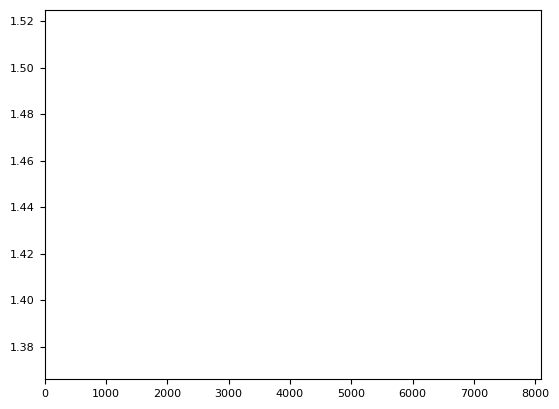

3it [00:00, 27.74it/s]

Epoch 0, loss 1.4454121589660645


993it [00:11, 88.02it/s]

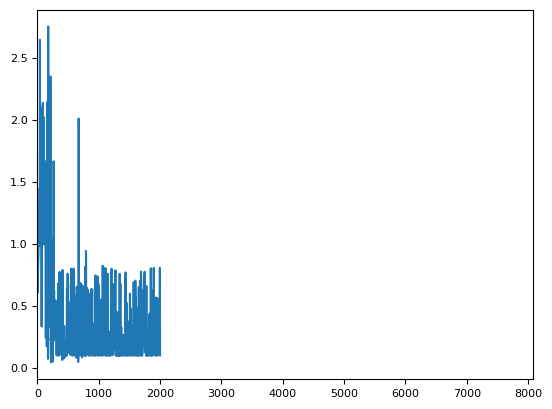

1011it [00:11, 86.79it/s]

Epoch 0, loss 0.2742076232880354


Epoch 0, validation loss 0.3271734580309172


0it [00:00, ?it/s]

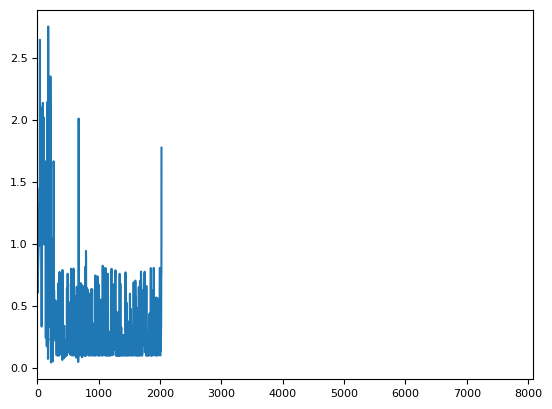

3it [00:00, 28.99it/s]

Epoch 1, loss 0.2786656301766634


993it [00:11, 87.78it/s]

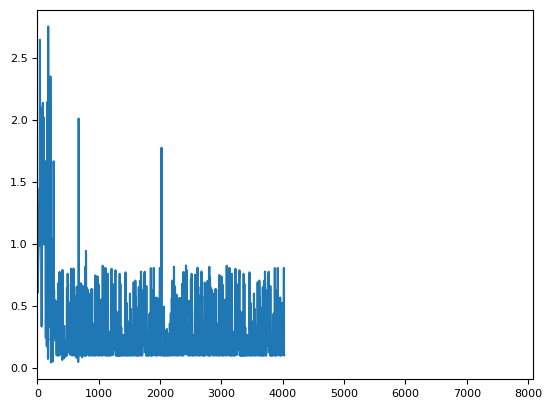

1011it [00:11, 86.42it/s]

Epoch 1, loss 0.2737760035842657


Epoch 1, validation loss 0.3271789462347059


0it [00:00, ?it/s]

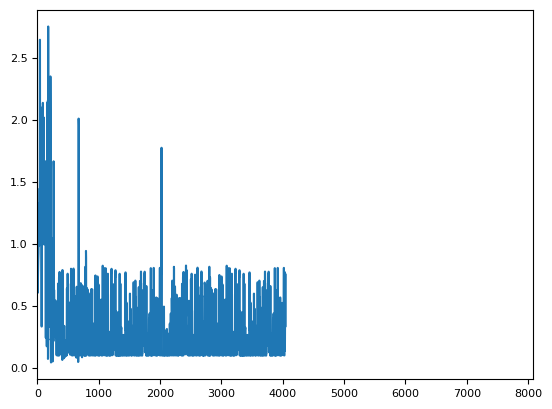

3it [00:00, 28.25it/s]

Epoch 2, loss 0.27679639057815075


993it [00:11, 87.82it/s]

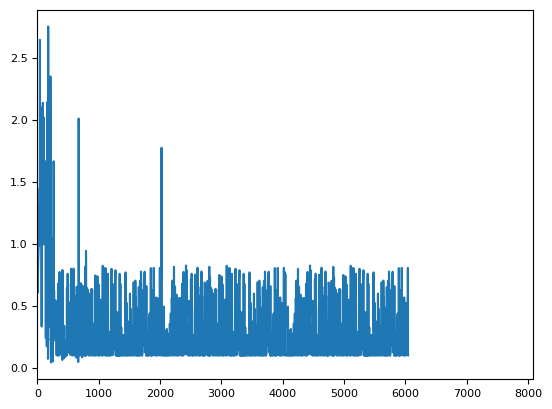

1011it [00:11, 86.40it/s]

Epoch 2, loss 0.2737692178636789


Epoch 2, validation loss 0.3271791712997221


0it [00:00, ?it/s]

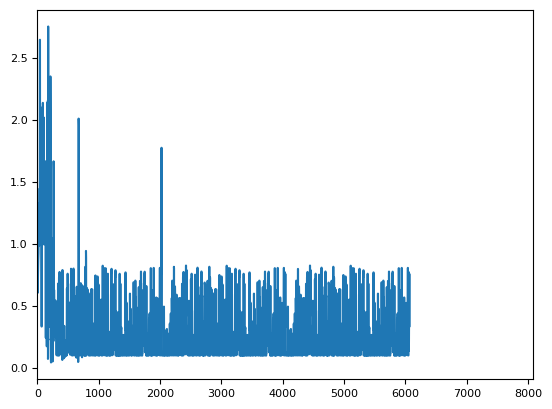

3it [00:00, 28.31it/s]

Epoch 3, loss 0.27678954748809337


993it [00:11, 87.89it/s]

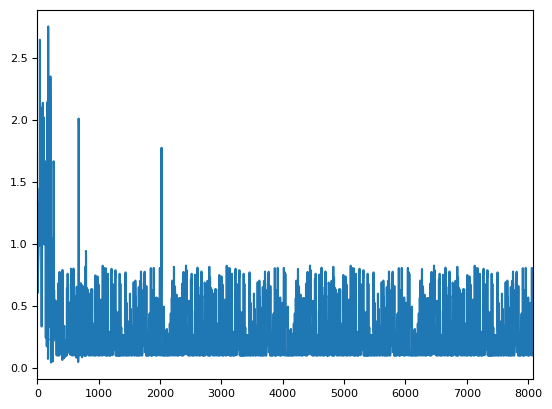

1011it [00:11, 86.63it/s]

Epoch 3, loss 0.27376855777204034


Epoch 3, validation loss 0.3271791725820179
Epoch 00004: reducing learning rate of group 0 to 1.0000e-04.


0it [00:00, ?it/s]

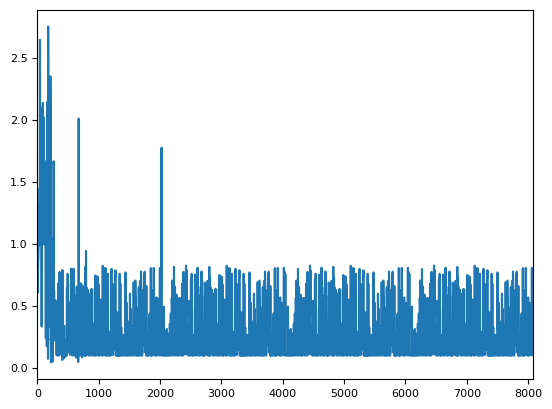

3it [00:00, 27.77it/s]

Epoch 4, loss 0.27678888727724554


993it [00:11, 87.85it/s]

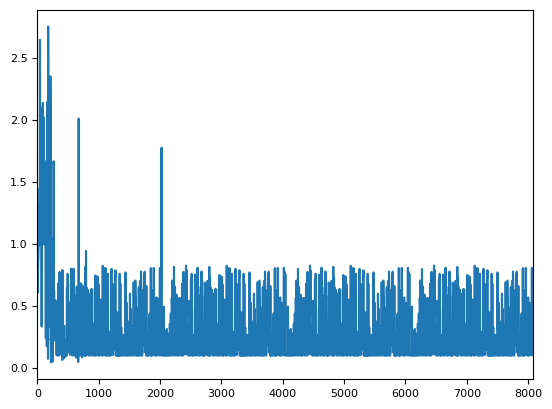

1011it [00:11, 86.45it/s]

Epoch 4, loss 0.2737684118449688


Epoch 4, validation loss 0.3271791727588863


0it [00:00, ?it/s]

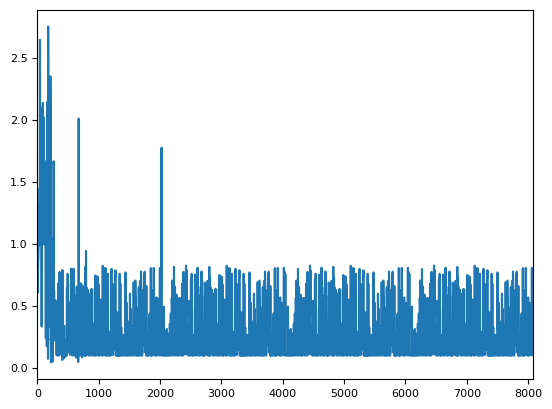

3it [00:00, 27.90it/s]

Epoch 5, loss 0.27678874135017395


993it [00:11, 87.72it/s]

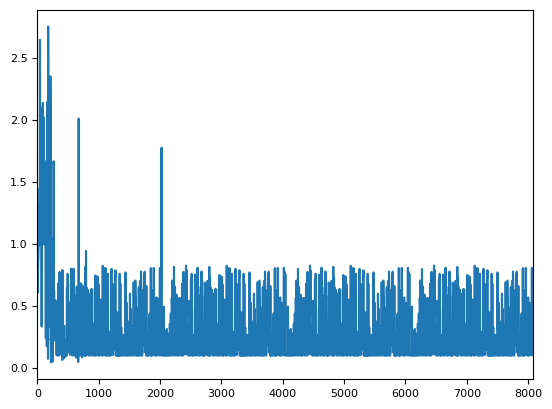

1011it [00:11, 85.77it/s]

Epoch 5, loss 0.2737683942168951


Epoch 5, validation loss 0.3271791727588863


0it [00:00, ?it/s]

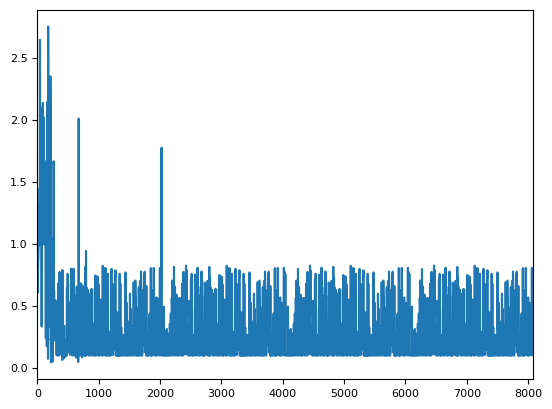

3it [00:00, 27.14it/s]

Epoch 6, loss 0.2767887237221003


993it [00:11, 87.16it/s]

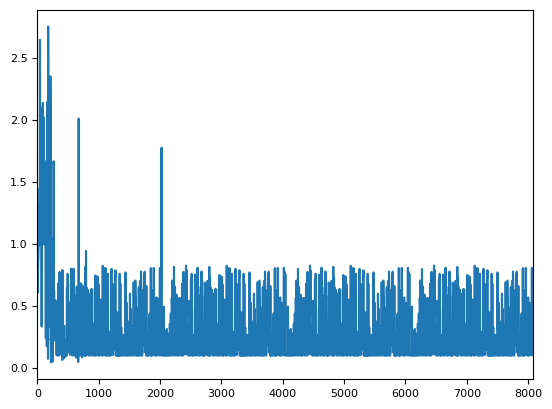

1011it [00:11, 86.40it/s]

Epoch 6, loss 0.2737683919519186


Epoch 6, validation loss 0.3271791727588863
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


0it [00:00, ?it/s]

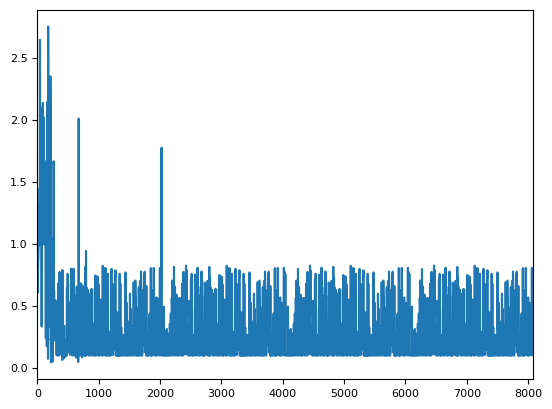

3it [00:00, 27.43it/s]

Epoch 7, loss 0.27678872145712374


993it [00:11, 89.00it/s]

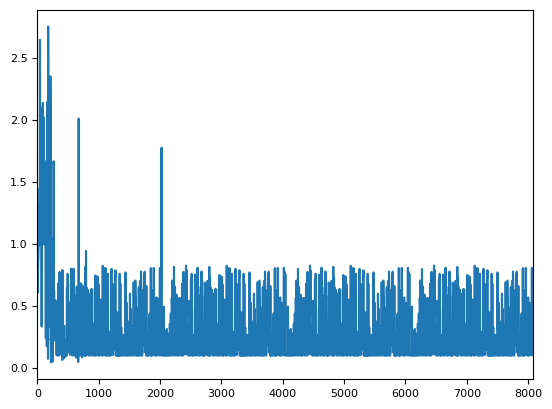

1011it [00:11, 85.75it/s]

Epoch 7, loss 0.27376839135587216


Epoch 7, validation loss 0.3271791727588863


In [91]:
# Run the training loop
hyperparameters = {'epochs': epochs, 'iters_per_dialog': iters_per_dialog, 'smooth_labels': True}
model = GCLWithHeadBert(character_embedding_dim, bert_dim, edge_dim, 1).to(torch_device)
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-2)
criterion = SignedMSELoss()
scheduler = get_scheduler(optimizer)
character_embeddings = torch.rand((len(character_enum), character_embedding_dim)).to(torch_device)
losses, all_losses, val_losses = train_loop(model, optimizer, criterion, scheduler, character_embeddings, train_data, valid_data, hyperparameters)

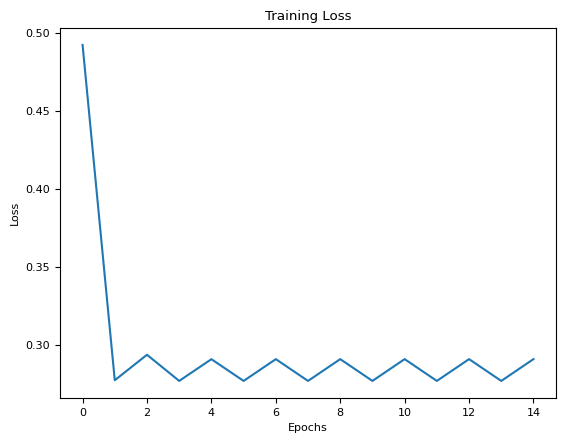

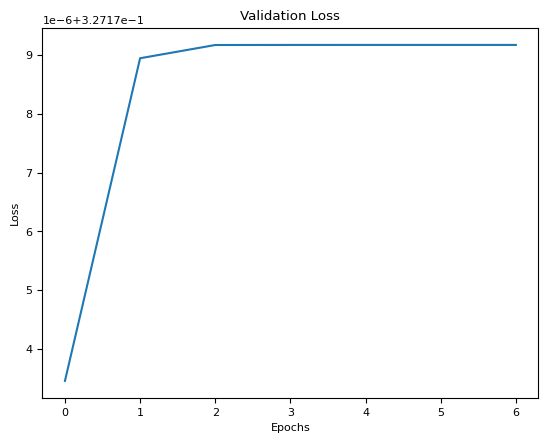

In [93]:
def get_avg_losses(loss, size):
    """
    For the list of losses, create a new list averaging together every size elements
    """
    avg_loss = []
    for i in range(0, len(loss), size):
        avg_loss.append(sum(loss[i:i+size])/size)
    return avg_loss[:-1]
  
avg_losses = get_avg_losses(all_losses, 1011)
plt.plot(range(len(avg_losses)), avg_losses)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

avg_val_losses = get_avg_losses(val_losses, 1)
plt.plot(range(len(avg_val_losses)), avg_val_losses)
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Evaluation Loop

In [94]:
def eval_loop(model, criterion, character_embeddings, test_data, verbose = True):
  correct, incorrect = 0, 0
  losses = []
  for index, row in tqdm.tqdm(test_data.iterrows()):
    dialog_gt = row['dialogue_sentiment']
    y = torch.tensor(dialog_gt).view(-1, 1).to(torch_device)
    
    # Forward pass: Compute predicted y by passing x to the model
    bert_value = get_bert_embedding(row)
    bert_row = np.array([float(val) for val in bert_value.strip('][').split(', ')])
    bert_embed = torch.from_numpy(bert_row).float().to(torch_device)
    speaker = torch.tensor([get_speaker(row)]).to(torch_device)
    listener = torch.tensor([get_listener(row)]).to(torch_device)

    with torch.no_grad():
      character_embeddings, y_pred = model(character_embeddings, bert_embed, speaker, 
                                            listener)
      
    # if y_pred and y are the same sign, increment correct, else increment incorrect
    if y_pred.item() * y.item() > 0:
      correct += 1
    else:
      incorrect += 1

    # Compute and print loss
    loss = criterion(y_pred, y)
    losses.append(loss.item())

  if verbose:
    # printing correctness/incorrect measured by direction
    print('accuracy', correct/(correct + incorrect))
  correctness = correct / (correct + incorrect)

  # printing accuracy based on loss
  loss_np = np.array(losses)
  accuracies = []
  for boundary in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    boolean = loss_np[loss_np <= boundary]
    if verbose:
      print(f"With error margin {boundary}, accuracy = {len(boolean) / len(loss_np)}")
    accuracies.append(len(boolean) / len(loss_np))
  if verbose:
    plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], accuracies, label='MSE Loss')
    plt.xlabel('Margin')
    plt.ylabel('Percent within Margin')
    plt.title('Loss Percent within Loss Margin')

  return losses, correctness, accuracies

338it [00:00, 965.62it/s]

accuracy 0.6301775147928994
With error margin 0.1, accuracy = 0.026627218934911243
With error margin 0.2, accuracy = 0.5
With error margin 0.3, accuracy = 0.5769230769230769
With error margin 0.4, accuracy = 0.7011834319526628
With error margin 0.5, accuracy = 0.757396449704142
With error margin 0.6, accuracy = 0.8165680473372781
With error margin 0.7, accuracy = 0.8875739644970414
With error margin 0.8, accuracy = 0.9319526627218935
With error margin 0.9, accuracy = 0.9792899408284024
With error margin 1, accuracy = 0.9822485207100592


([0.2825179994106293,
  0.252002477645874,
  0.245934396982193,
  0.1295953392982483,
  0.14596527814865112,
  0.1118539497256279,
  0.12232449650764465,
  0.17236004769802094,
  0.18432265520095825,
  0.17400433123111725,
  0.16137975454330444,
  0.1478777974843979,
  0.13916757702827454,
  0.3014586269855499,
  0.3201073110103607,
  0.3237033784389496,
  0.3395187258720398,
  0.2731998860836029,
  0.20495197176933289,
  0.17656415700912476,
  0.14808662235736847,
  0.11636653542518616,
  0.11307476460933685,
  0.12589852511882782,
  0.12085969746112823,
  0.5606759190559387,
  0.5901303887367249,
  0.6086680889129639,
  0.5373378396034241,
  0.15953972935676575,
  0.1681717038154602,
  0.22339928150177002,
  0.23015066981315613,
  0.1770251989364624,
  0.1833188235759735,
  0.5721620321273804,
  0.5641536712646484,
  0.1032361388206482,
  0.11449022591114044,
  0.11465486139059067,
  0.10868385434150696,
  0.16834232211112976,
  0.17222146689891815,
  0.13128945231437683,
  0.1286534

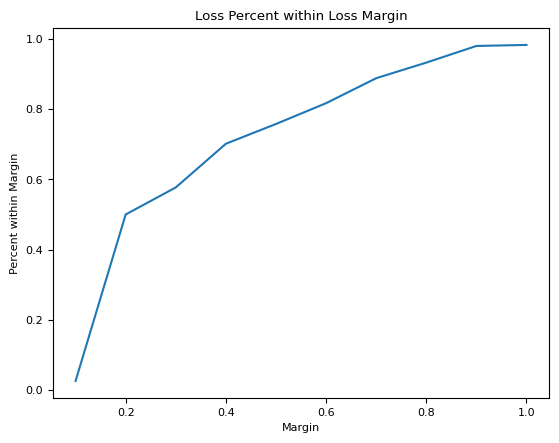

In [95]:
eval_loop(model, criterion, character_embeddings, test_data)

## Plotting Embeddings

In [ ]:
# create a 2D plot of the vectors
def plot_2d(vectors, labels):
    tsne = TSNE(n_components=2, perplexity=1, random_state=0)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(vectors)
    labels = labels

    df = px.data.iris()
    fig = px.scatter(x=T[:,0], y=T[:,1], color=labels)
    fig.show()

In [ ]:
plot_2d(character_embeddings.cpu().detach().numpy(), character_enum['character'])

## HyperParameter Search

In [ ]:
# Set up hyperparameter for grid search
character_embedding_dims = [4, 8, 16, 32, 64, 128]
bert_dims = [768]
edge_dims = [2, 4, 8, 16, 32, 64, 128]
epochs = [1]
iters_per_dialog = [1]

In [ ]:
# save data here
data = {}

In [ ]:
# Save data to file as checkpoint
with open('grid_search_data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
# Perform grid search
for character_embedding_dim in character_embedding_dims:
    for bert_dim in bert_dims:
        for edge_dim in edge_dims:
            for epoch_count in epochs:
                for iters_count in iters_per_dialog:
                    print('Testing: ', character_embedding_dim, bert_dim, edge_dim, epoch_count, iters_count)
                    # Run the training loop
                    hyperparameters = {'epochs': epoch_count, 'iters_per_dialog': iters_count}
                    model = GCLWithHeadBert(character_embedding_dim, bert_dim, edge_dim, 1).to(torch_device)
                    optimizer = torch.optim.Adam(model.parameters())
                    criterion = SignedMSELoss()
                    scheduler = get_scheduler(optimizer)
                    character_embeddings = torch.rand((len(character_enum), character_embedding_dim)).to(torch_device)
                    losses, all_losses, val_losses = train_loop(model, optimizer, criterion, scheduler, character_embeddings, train_data, valid_data, hyperparameters, print_every=10000)
                    losses_eval, correctness, accuracies = eval_loop(model, criterion, character_embeddings, test_data, verbose=False)
                    # save data here
                    data[(character_embedding_dim, bert_dim, edge_dim, epoch_count, iters_count)] = (losses, all_losses, val_losses, losses_eval, correctness, accuracies)
    
    # Save data to file as checkpoint
    with open('grid_search_data.pkl', 'wb') as f:
        pickle.dump(data, f)


In [ ]:
# Plot the following: Average loss value against values of edge_dim
# (losses, all_losses, val_losses, losses_eval, correctness, accuracies)
losses = []
losses2 = []
accuracies = []
accuracies2 = []
for edge_dim in edge_dims:
    avg_losses = get_avg_losses(data[(16, 768, edge_dim, 1, 1)][1], 1011)
    accuracies.append(data[(16, 768, edge_dim, 1, 1)][5][1])
    losses.append(avg_losses[-1])

for char_dim in character_embedding_dims:
    avg_losses = get_avg_losses(data[(char_dim, 768, 16, 1, 1)][1], 1011)
    accuracies2.append(data[(char_dim, 768, 16, 1, 1)][5][1])
    losses2.append(avg_losses[-1])

# Create four subplots 
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5, 5))
# Add space between plots
fig.tight_layout(pad=5.0)
# Decrease font size
plt.rcParams.update({'font.size': 8})
ax1.plot(edge_dims, accuracies)
ax1.set_title('Accuracy vs. Edge Dimension')
ax1.set_xlabel('Edge Dimension')
ax1.set_ylabel('Accuracy')
ax2.plot(edge_dims, losses)
ax2.set_title('Loss vs. Edge Dimension')
ax2.set_xlabel('Edge Dimension')
ax2.set_ylabel('Loss')
ax3.plot(character_embedding_dims, accuracies2)
ax3.set_title('Accuracy vs. Char Embed Dim')
ax3.set_xlabel('Character Embedding Dimension')
ax3.set_ylabel('Accuracy')
ax4.plot(character_embedding_dims, losses2)
ax4.set_title('Loss vs. Char Embed Dim')
ax4.set_xlabel('Character Embedding Dimension')
ax4.set_ylabel('Loss')
plt.show()


## Manual Testing

In [ ]:
character_translation = {index: name for index, name in enumerate(character_enum['character'])}
juliet_side = ["JULIET", "NURSE", "LADY CAPULET", "CAPULET"]
romeo_side = ["ROMEO", "FRIAR LAWRENCE", "FRIAR JOHN", "BALTHASAR", "MERCUTIO", "BENVOLIO", "MONTAGUE"]
evil_side = ["TYBALT", "PARIS", "PRINCE", "APOTHECARY"]

name_to_index = {v:k for k,v in character_translation.items()}
juliet_indices = [name_to_index[name] for name in juliet_side]
romeo_indices = [name_to_index[name] for name in romeo_side]
evil_indices = [name_to_index[name] for name in evil_side]

juliet_friends = [character_embeddings[index].detach().cpu().numpy() for index in juliet_indices]
romeo_friends = [character_embeddings[index].detach().cpu().numpy() for index in romeo_indices]
evil_friends = [character_embeddings[index].detach().cpu().numpy() for index in evil_indices]

juliet = juliet_friends[0]
romeo = romeo_friends[0]

juliet_distances = [np.linalg.norm(juliet - friend) for friend in juliet_friends]
romeo_distances = [np.linalg.norm(romeo - friend) for friend in romeo_friends]

juliet_romeo_distances = [np.linalg.norm(juliet - other) for other in romeo_friends]
juliet_evil_distances = [np.linalg.norm(juliet - other) for other in evil_friends]

romeo_juliet_distances = [np.linalg.norm(romeo - other) for other in juliet_friends]
romeo_evil_distances = [np.linalg.norm(romeo - other) for other in evil_friends]

print(np.mean(juliet_distances), np.mean(juliet_romeo_distances), np.mean(juliet_evil_distances))
print(np.mean(romeo_distances), np.mean(romeo_juliet_distances), np.mean(romeo_evil_distances))